In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50
dir = '/content/drive/MyDrive/defects'

In [ ]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1392 files belonging to 4 classes.


In [ ]:
class_names = df.class_names
class_names

['crack', 'dent', 'erosion', 'scratch']

In [ ]:
for image_batch, labels_batch in df.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 3 3 3 0 3 2 3 0 1 0 2 2 3 0 1 3 3 0 3 2 2 0 3 3 0 3 2 0 1 2 3]


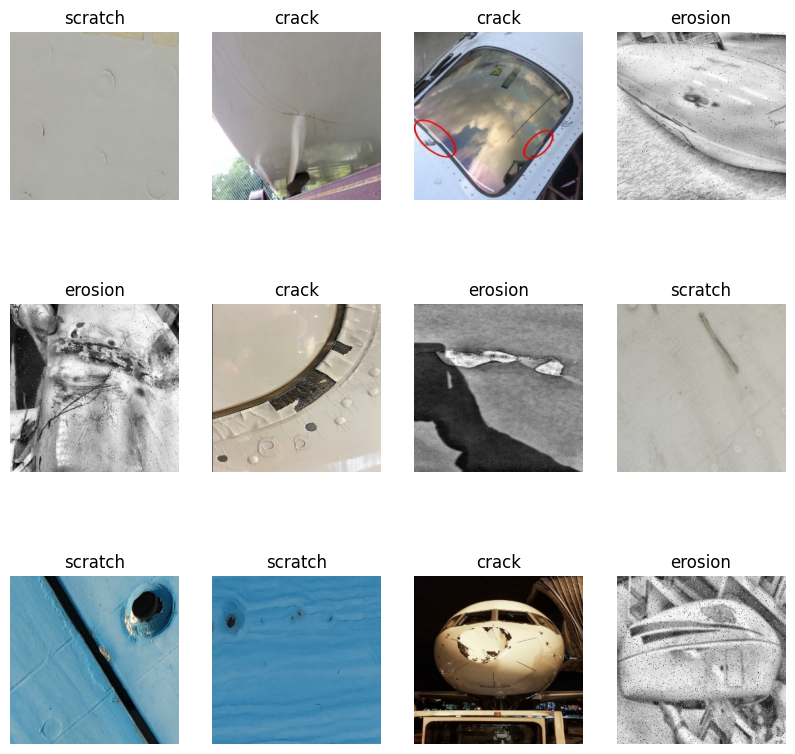

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in df.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(df) #defines batch size

44

In [ ]:
train_size = 0.8
len(df)*train_size

35.2

In [ ]:
train_ds = df.take(35)
len(train_ds)

35

In [ ]:
test_ds = df.skip(35)
len(test_ds)

9

In [ ]:
val_size=0.1
len(df)*val_size

4.4

In [ ]:
val_ds = test_ds.take(4)
len(val_ds)

4

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

3

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(df)

In [ ]:
len(train_ds)

35

In [ ]:
len(val_ds)

4

In [ ]:
len(test_ds)

5

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
35/35 [==============================] - 318s 412ms/step - loss: nan - accuracy: 0.3732 - val_loss: nan - val_accuracy: 0.3750
Epoch 2/50
35/35 [==============================] - 10s 291ms/step - loss: nan - accuracy: 0.3795 - val_loss: nan - val_accuracy: 0.3750
Epoch 3/50
35/35 [==============================] - 9s 267ms/step - loss: nan - accuracy: 0.3795 - val_loss: nan - val_accuracy: 0.3750
Epoch 4/50
35/35 [==============================] - 10s 269ms/step - loss: nan - accuracy: 0.3795 - val_loss: nan - val_accuracy: 0.3750
Epoch 5/50
35/35 [==============================] - 10s 297ms/step - loss: nan - accuracy: 0.3795 - val_loss: nan - val_accuracy: 0.3750
Epoch 6/50
35/35 [==============================] - 10s 286ms/step - loss: nan - accuracy: 0.3795 - val_loss: nan - val_accuracy: 0.3750
Epoch 7/50
35/35 [==============================] - 11s 303ms/step - loss: nan - accuracy: 0.3795 - val_loss: nan - val_accuracy: 0.3750
Epoch 8/50
35/35 [=======================

In [ ]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 9s 38ms/step - loss: nan - accuracy: 0.3625


In [ ]:
scores

[nan, 0.36250001192092896]

In [43]:
history

In [44]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 35}

In [45]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [46]:
type(history.history['loss'])

list

In [47]:
len(history.history['loss'])

50

In [48]:
history.history['loss'][:5] # show loss for first 5 epochs

[nan, nan, nan, nan, nan]

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

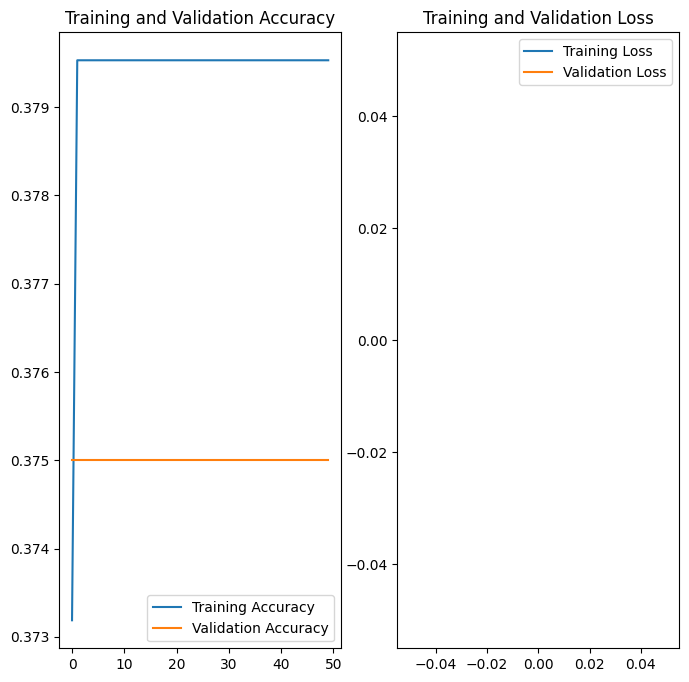

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: scratch
1/1 [==============================] - 0s 239ms/step
predicted label: crack


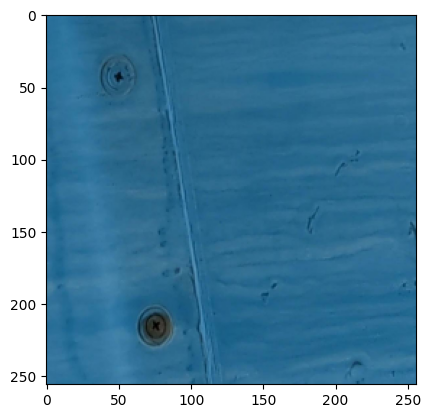

In [51]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [52]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


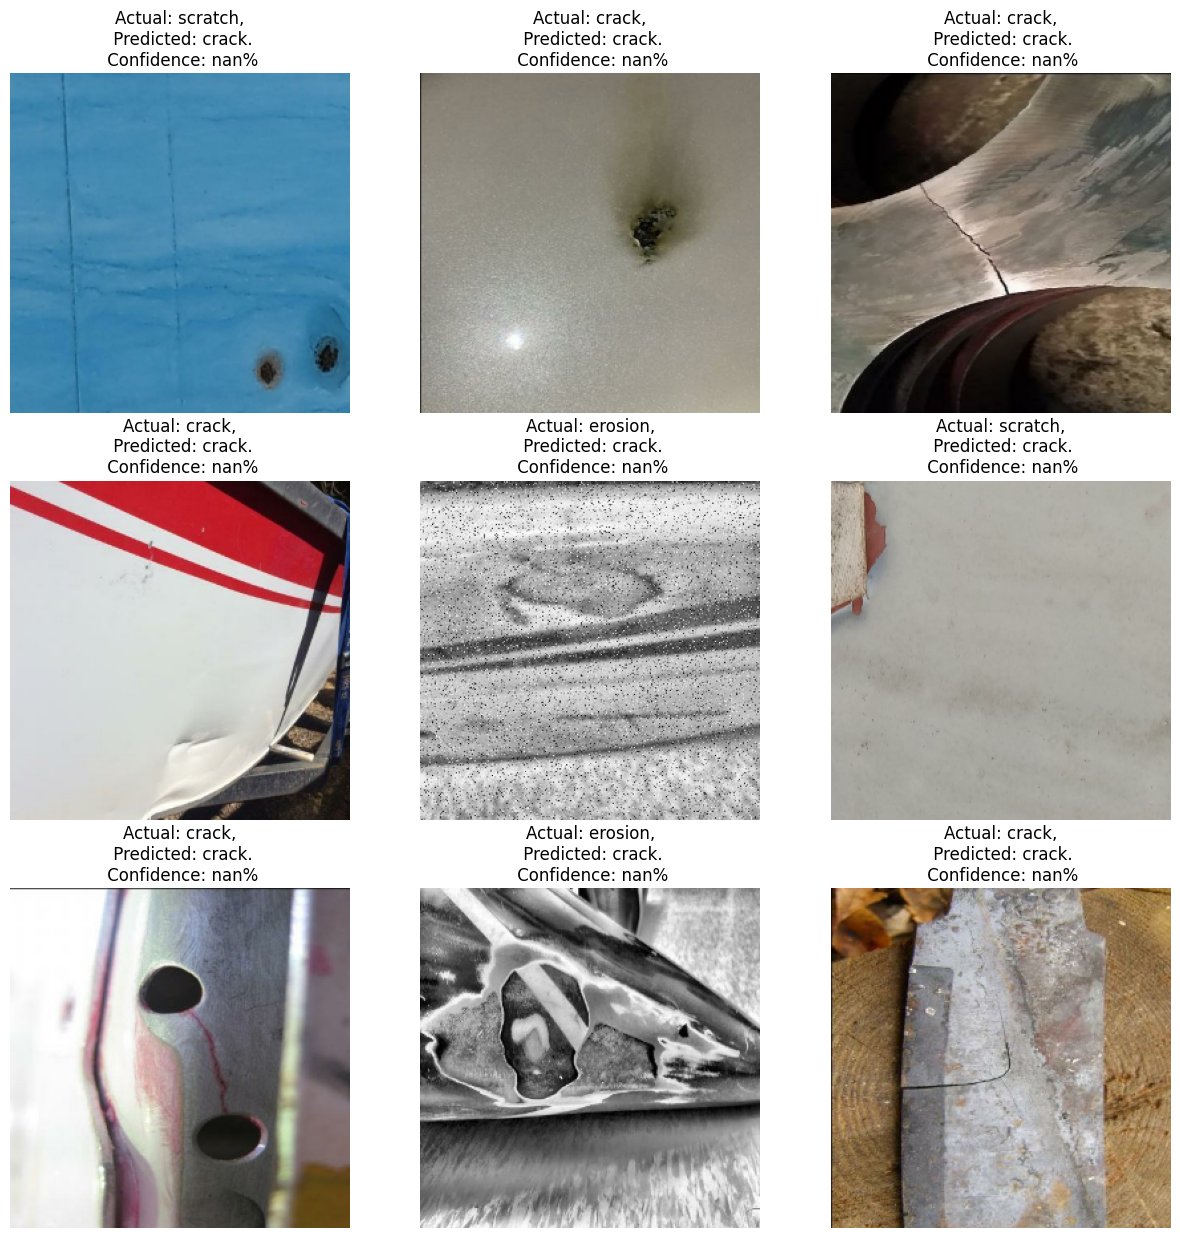

In [53]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")